In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import numpy as np
from dataset import ColorizeHD5Dataset

We want to discretize the LAB color space into bins of 10x10

In [4]:
# we create a fake 256 by 256*256 image which gives us all possible combinations of RGB
lookup = np.zeros((256, 256*256, 3), dtype=np.uint8)
for r in range(256):
    for g in range(256):
        for b in range(256):
            lookup[r, g*256+b, :] = np.array([r, g, b], dtype=np.uint8) 
    

In [5]:
lookup[0,256,:]

array([0, 1, 0], dtype=uint8)

In [6]:
lookup_lab = rgb2lab(lookup)

In [7]:
lookup_lab[:,:,1].min()

-86.18302974439501

In [8]:
stride = len(range(-128, 128, 10))
bins = np.zeros((stride, stride))
lookup_a = lookup_lab[:,:,1].reshape(-1)
lookup_b = lookup_lab[:,:,2].reshape(-1)
lookup_a_idx = np.uint8(np.floor((lookup_a + 128) / 10))
lookup_b_idx =  np.uint8(np.floor((lookup_b + 128) / 10))
bins[lookup_a_idx, lookup_b_idx] = 1

In [9]:
stacked_idx = np.stack((lookup_a_idx, lookup_b_idx))
uniq_idx = np.unique(stacked_idx, axis=1).T
np.save('lab_idx.npy', uniq_idx)

## Everything above is checkpointed

In [165]:
idx_to_bin_idx = np.load('lab_idx.npy')

In [166]:
idx_to_lab = np.double(idx_to_bin_idx) * 10 - 128 + 5

In [167]:
bin_idx_to_idx = np.zeros((stride, stride))
bin_idx_to_idx[idx_to_bin_idx[:,0], idx_to_bin_idx[:,1]] = np.arange(idx_to_bin_idx.shape[0]) 
bin_idx_to_idx = np.uint8(bin_idx_to_idx)

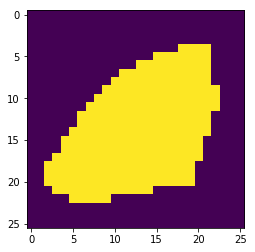

In [168]:
plt.imshow(bin_idx_to_idx > 0)

In [169]:
def encode_lab_to_histo(ab):
    assert ab.shape[2] == 2, 'need shape (H x W X 2)'
    a_bin_idx = np.uint8((ab[:,:,0] + 128) / 10)
    b_bin_idx = np.uint8((ab[:,:,1] + 128) / 10)
    return bin_idx_to_idx[a_bin_idx, b_bin_idx]
    
def decode_histo_to_ab(idx):
    assert len(idx.shape) == 2, 'need shape (H x W)'
    return idx_to_lab[idx, :]



In [170]:
a = np.array([[1,1,2], [1,1,3]])

In [171]:
a[[0,1],[0,1]] = [6,7]

In [172]:
a

array([[6, 1, 2],
       [1, 7, 3]])

In [173]:
idx_to_lab[[[1,2,3],[3,4,5], [5,6,7]],:].shape

(3, 3, 2)

In [174]:
img = ds_train.get_pil(0)
rgb_hwc = np.asarray(img)
lab_hwc = rgb2lab(rgb_hwc)

In [175]:
idx_img = encode_lab_to_histo(lab_hwc[:,:,1:])

In [176]:
decoded_img = decode_histo_to_ab(idx_img)

In [177]:
idx_img

array([[ 64,  64,  64, ..., 100, 100, 100],
       [ 64,  64,  64, ..., 100, 100, 100],
       [ 64,  64,  64, ..., 100, 100, 100],
       ...,
       [ 63,  63,  63, ...,  65,  65,  65],
       [ 63,  63,  63, ...,  65,  65,  65],
       [ 63,  63,  63, ...,  65,  65,  65]], dtype=uint8)

In [178]:
np.abs(lab_hwc[:,:,1:] - decoded_img).max()

4.999989146124371

### Wrap it in a class